<a href="https://colab.research.google.com/github/Parimala-15/ShadowFox/blob/main/Image_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision torchsummary numpy matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 100.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np

In [18]:
import torch

# Check device availability
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ Using GPU: CUDA")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # For Macbooks with Apple Silicon
    print("✅ Using GPU: Apple MPS")
else:
    device = torch.device("cpu")
    print("⚠️ Using CPU (slowest).")

# Optional: Double check
print(f"Using device: {device}")


✅ Using GPU: CUDA
Using device: cuda


In [27]:
# Training: Add augmentation
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Validation/Test: Only normalize
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


In [29]:
# Re-create original dataset with `transform=None` so we can apply it manually to subsets
base_train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=None)

# Split the raw dataset
train_size = int(0.8 * len(base_train_set))
val_size = len(base_train_set) - train_size
train_dataset_raw, val_dataset_raw = random_split(base_train_set, [train_size, val_size])

# Manually apply transforms using transforms property
train_dataset_raw.dataset.transform = train_transform
val_dataset_raw.dataset.transform = test_transform

# Create loaders
train_loader = torch.utils.data.DataLoader(train_dataset_raw, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset_raw, batch_size=4, shuffle=False)

# Test set with test_transform
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=4, shuffle=False)


In [28]:

print('Number of images in the training dataset:', len(train_set))
print('Number of images in the testing dataset:', len(test_set))


Number of images in the training dataset: 50000
Number of images in the testing dataset: 10000


In [6]:
print(f"Shape of the images in the training dataset: {train_loader.dataset[0][0].shape}")

Shape of the images in the training dataset: torch.Size([3, 32, 32])


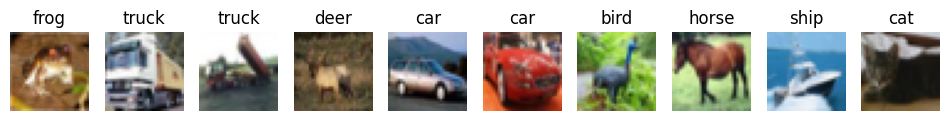

In [7]:

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for i in range(10):
    image = train_loader.dataset[i][0].permute(1, 2, 0)
    denormalized_image= image / 2 + 0.5
    axes[i].imshow(denormalized_image)
    axes[i].set_title(classes[train_loader.dataset[i][1]])
    axes[i].axis('off')
plt.show()

In [17]:

class ConvNeuralNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),      # (3,32,32) → (64,32,32)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                              # → (64,16,16)

            nn.Conv2d(64, 128, kernel_size=3, padding=1),    # → (128,16,16)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                              # → (128,8,8)

            nn.Conv2d(128, 256, kernel_size=3, padding=1),   # → (256,8,8)
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                              # → (256,4,4)

            nn.Dropout(0.3)
        )

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))          # → (256,1,1)

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x



net = ConvNeuralNet()
net.to(device)

ConvNeuralNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.3, inplace=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=

In [9]:
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           1,792
         MaxPool2d-2           [-1, 64, 15, 15]               0
            Conv2d-3          [-1, 128, 13, 13]          73,856
         MaxPool2d-4            [-1, 128, 6, 6]               0
            Linear-5                  [-1, 120]         553,080
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 639,742
Trainable params: 639,742
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.75
Params size (MB): 2.44
Estimated Total Size (MB): 3.20
----------------------------------------------------------------


In [10]:

loss_function = nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):

    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = loss_function(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            print(f'[{epoch + 1}/{epochs}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')


[1/10,  2000] loss: 1.799
[1/10,  4000] loss: 1.510
[1/10,  6000] loss: 1.432
[1/10,  8000] loss: 1.345
[1/10, 10000] loss: 1.324
[1/10, 12000] loss: 1.278
[2/10,  2000] loss: 1.201
[2/10,  4000] loss: 1.178
[2/10,  6000] loss: 1.133
[2/10,  8000] loss: 1.132
[2/10, 10000] loss: 1.107
[2/10, 12000] loss: 1.128
[3/10,  2000] loss: 1.042
[3/10,  4000] loss: 1.048
[3/10,  6000] loss: 1.044
[3/10,  8000] loss: 1.029
[3/10, 10000] loss: 1.046
[3/10, 12000] loss: 1.030
[4/10,  2000] loss: 0.959
[4/10,  4000] loss: 0.947
[4/10,  6000] loss: 0.969
[4/10,  8000] loss: 0.990
[4/10, 10000] loss: 0.979
[4/10, 12000] loss: 0.961
[5/10,  2000] loss: 0.875
[5/10,  4000] loss: 0.904
[5/10,  6000] loss: 0.929
[5/10,  8000] loss: 0.905
[5/10, 10000] loss: 0.926
[5/10, 12000] loss: 0.937
[6/10,  2000] loss: 0.848
[6/10,  4000] loss: 0.856
[6/10,  6000] loss: 0.885
[6/10,  8000] loss: 0.883
[6/10, 10000] loss: 0.883
[6/10, 12000] loss: 0.872
[7/10,  2000] loss: 0.797
[7/10,  4000] loss: 0.840
[7/10,  6000

In [11]:
def view_classification(image, probabilities):
    probabilities = probabilities.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)

    image = image.permute(1, 2, 0)
    denormalized_image= image / 2 + 0.5
    ax1.imshow(denormalized_image)
    ax1.axis('off')
    ax2.barh(np.arange(10), probabilities)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(classes)
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

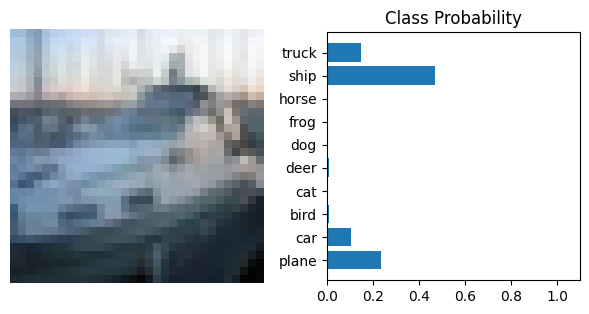

In [15]:

images, _ = next(iter(test_loader))

image = images[2]
batched_image = image.unsqueeze(0).to(device)
with torch.no_grad():
    log_probabilities = net(batched_image)

probabilities = torch.exp(log_probabilities).squeeze().cpu()
view_classification(image, probabilities)

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [20]:
y_true = []
y_pred = []

net.eval()  # Set to eval mode

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())


In [21]:
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=classes))



📊 Classification Report:

              precision    recall  f1-score   support

       plane       0.00      0.00      0.00      1000
         car       0.10      1.00      0.18      1000
        bird       0.00      0.00      0.00      1000
         cat       0.00      0.00      0.00      1000
        deer       0.00      0.00      0.00      1000
         dog       0.00      0.00      0.00      1000
        frog       0.00      0.00      0.00      1000
       horse       0.00      0.00      0.00      1000
        ship       0.00      0.00      0.00      1000
       truck       0.00      0.00      0.00      1000

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


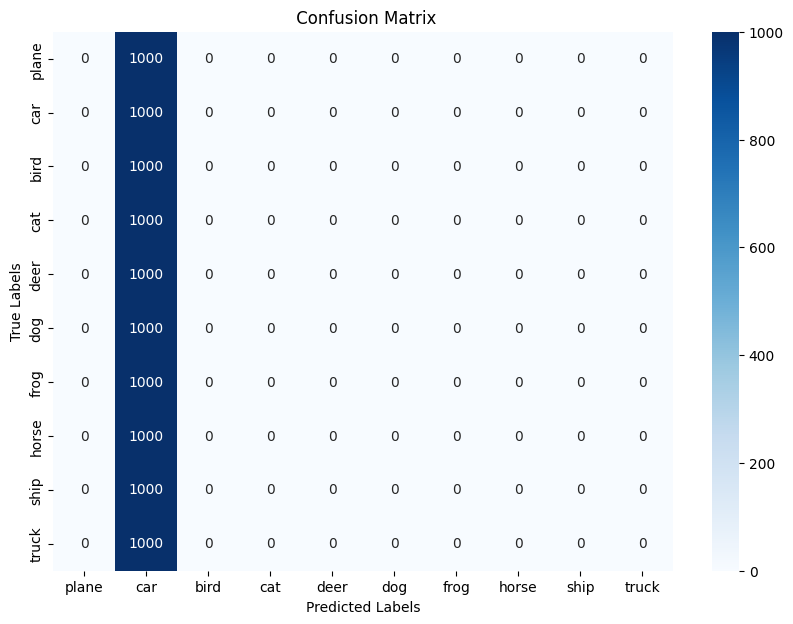

In [23]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title(' Confusion Matrix')
plt.show()


In [24]:
from torch.utils.data import random_split

# Define split sizes
train_size = int(0.8 * len(train_set))   # 80% for training
val_size = len(train_set) - train_size   # 20% for validation

# Create splits
train_dataset, val_dataset = random_split(train_set, [train_size, val_size])


In [25]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)


In [26]:
# After training loop per epoch
val_loss = 0.0
net.eval()  # evaluation mode disables dropout, etc.
with torch.no_grad():
    for val_inputs, val_labels in val_loader:
        val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
        val_outputs = net(val_inputs)
        val_loss += loss_function(val_outputs, val_labels).item()

avg_val_loss = val_loss / len(val_loader)
print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}")
net.train()  # switch back to training mode


Epoch [10/10], Validation Loss: 2.3039


ConvNeuralNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.3, inplace=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=

In [37]:
# Save model state dict
torch.save(net.state_dict(), 'cnn_cifar10.pth')
print("🧠 Model saved as 'cnn_cifar10.pth'")


🧠 Model saved as 'cnn_cifar10.pth'


In [32]:
# Load model
loaded_model = ConvNeuralNet()
loaded_model.load_state_dict(torch.load('cnn_cifar10.pth', map_location=device))
loaded_model.to(device)
loaded_model.eval()


ConvNeuralNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout(p=0.3, inplace=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=

In [33]:
from PIL import Image

def predict_image(image_path, model, transform, class_names):
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image)
        probs = torch.exp(output)
        top_p, top_class = probs.topk(1, dim=1)

    predicted_class = class_names[top_class.item()]
    confidence = top_p.item()
    return predicted_class, confidence
